In [2]:
import mne,os
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import pandas as pd 

def make_basis_function():
    ori_angles = 360
    n_channels = 8

    sin_wave = np.sin(np.arange(0, np.pi * 2, np.pi * 2 / ori_angles))
    sin_wave[sin_wave<0] = 0
    sin_wave = sin_wave**2

    plt.close('all')
    all_basis_functions = []
    for hue_tuned in np.arange(0,ori_angles,ori_angles/n_channels):
        basis_function = np.zeros(ori_angles)
        start = int(hue_tuned-ori_angles/2)
        x = np.arange(start,start+sin_wave.shape[0])
        x[x>359]=x[x>359]-360
        basis_function[x] = sin_wave
        all_basis_functions.append(basis_function)
        plt.plot(basis_function,'grey')
    [plt.gca().spines[i].set_visible(False) for i in ['top','right']]
    plt.show()
    plt.gcf().savefig('./basis_function.png')

    return np.array(all_basis_functions)


def train_test_split(epochs,test_chunk,target_id,cv_id='session_nr'):
    # break data into training and testing set for cross-validation
    epochs_test = epochs[epochs.metadata[cv_id]==test_chunk]
    epochs_train = epochs[epochs.metadata[cv_id]!=test_chunk]
    X_test = epochs_test._data
    X_train = epochs_train._data

    # testing & training labels
    y_train = epochs_train.metadata[target_id].to_numpy()
    y_test = epochs_test.metadata[target_id].to_numpy()

    return X_train, X_test, y_train, y_test


def linear_regression(X_train, X_test, y_train, y_test,t):
    ridge_cv = RidgeCV(alphas=np.linspace(0.000001, 30000, 100), store_cv_values=True,alpha_per_target=True)
    
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('regression', ridge_cv)])
    pipe.fit(X_train[:,:,t],y_train)
    predictions = pipe.predict(X_test[:,:,t])
    
    best_alpha = pipe.named_steps['regression'].alpha_
    print(f"Best alpha: {best_alpha}")
    return predictions

def run_regression(epochs,cv_id):
    basis_function = make_basis_function()
    
    all_y_pred = []
    all_y_true = []
    all_y_true_deg = []
    for test_chunk in np.unique(epochs.metadata[cv_id]):
        print(f'running cv #{test_chunk} out of {len(np.unique(epochs.metadata[cv_id]))}')
        X_train, X_test, y_train, y_test = train_test_split(epochs=epochs,test_chunk=test_chunk,target_id='degrees',cv_id='run')
        print(type(y_train[1]))
        y_train_bf = basis_function[:,y_train].T
        y_test_bf = basis_function[:,y_test].T
        y_predicted = Parallel(n_jobs=8)(delayed(linear_regression)(X_train, X_test, y_train_bf, y_test_bf,t) for t in range(X_train.shape[2]))
        all_y_pred.append(y_predicted)
        all_y_true.append(y_test_bf)
        all_y_true_deg.append(y_test)
        
    return np.array(all_y_pred), np.array(all_y_true), np.array(all_y_true_deg)
        

In [3]:
# load data
data_path = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/'

fn_movie = 'S12datamovieNoCatch-epo.fif'
fn_still = 'S12dataStill-epo.fif' 
fn_miniepochs = 'miniEpochsnobaseline-epo.fif'

epochs_movie = mne.read_epochs(data_path+fn_movie)
epochs_still = mne.read_epochs(data_path+fn_still)
epochs_mini = mne.read_epochs(fn_miniepochs)


# add metadata to stills
df = pd.DataFrame()
labels  = [k.split('/')[-1] for k in epochs_still.event_id.keys()]
print(labels)
degrees = [0, 45, 90, 135, 180, 225, 270, 315]
df['degrees'] = [degrees[i] for i in epochs_still.events[:,2]-1]
df['run'] = np.repeat([1,2,3,4],160)
epochs_still.metadata = df


Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/S12datamovieNoCatch-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    3200.00 ms
        0 CTF compensation matrices available
Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Scripts/Processed_Data/S12dataStill-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
640 matching events found
No baseline correction applied
0 projection items activated
Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Lina/miniEpochsnobaseline-epo.fif ...


KeyboardInterrupt: 

In [8]:
print(df['degrees'])

0       45
1      315
2      225
3        0
4      270
      ... 
635    315
636    270
637    180
638    135
639      0
Name: degrees, Length: 640, dtype: int64


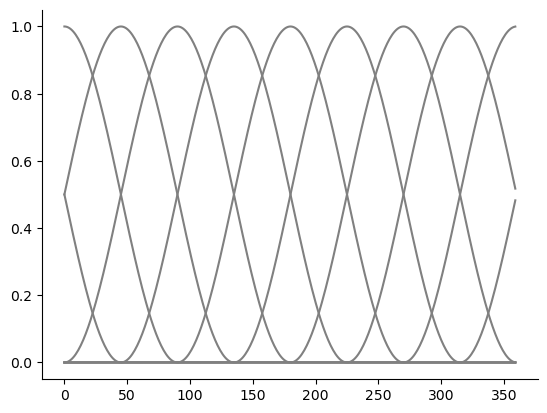

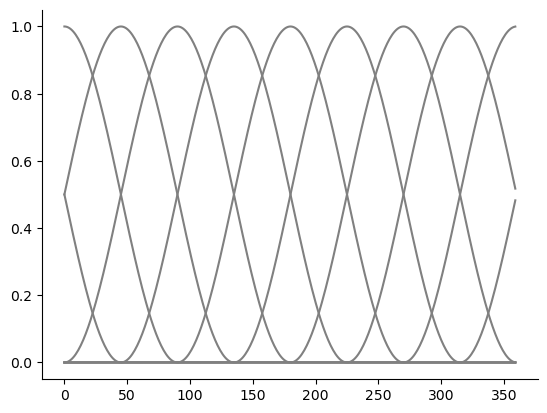

running cv #1 out of 4
<class 'numpy.int64'>


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [7]:
# run regression for the STILLS
bf = make_basis_function()
y_pred, y_true, y_true_deg = run_regression(epochs_still,'run')

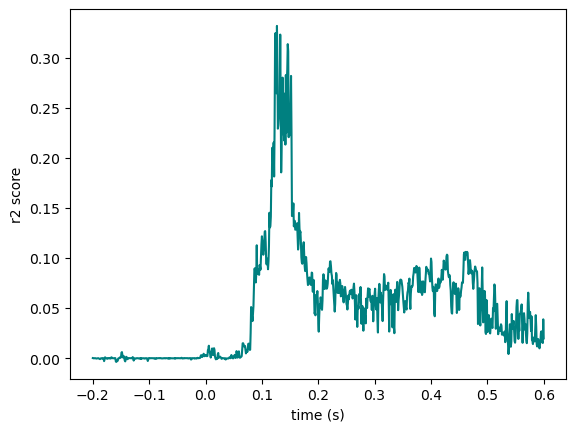

In [132]:
sort_order = np.array([np.argsort(y_true_deg[cv,:])  for cv in range(4)])    
y_pred_sorted = np.array([y_pred[cv,:,sort_order[cv,:],:] for cv in range(4)])
y_true_sorted = np.array([y_true[cv,sort_order[cv,:],:] for cv in range(4)])

# is averaging the right approach? I'm not sure...
y_pred_sorted_avg = np.mean(y_pred_sorted,axis=0)
y_true_sorted_avg = np.mean(y_true_sorted,axis=0)

plt.plot(epochs_still.times,[r2_score(y_true_sorted_avg.T,y_pred_sorted_avg[:,t,:].T) for t in range(len(epochs_still.times))],color='teal')
plt.xlabel('time (s)')
plt.ylabel('r2 score')

# reshape the data by appending different cross-validation folds
y_pred_sorted_reshaped = y_pred_sorted.reshape(-1, 961, 8)
y_true_sorted_reshaped = y_true_sorted.reshape(-1, 8)
order = np.sort(y_true_deg).reshape(-1)

plt.savefig(f'regression_res_timeseries.png')

In [1]:
# look at which degrees were predicted given each true degree angle
predicted_degrees = []
t_min = 360
t_max = 480
for deg in np.unique(order):
    predicted_degrees.append([np.argmin([np.sum(np.abs(bf[:,i]-np.mean(y_pred_sorted_reshaped[order==deg,t_min:t_max,:],axis=1)[rep,:])) for i in range(360)]) for rep in range(80)])

for true_ori_i, true_ori in enumerate(np.unique(order)):
    plt.close('all')
    fig = plt.figure()
    ax = plt.subplot(111, polar=True)

    radians = np.deg2rad(np.array(predicted_degrees)[true_ori_i, :])
    
    ax.hist(radians, bins=36, edgecolor='k', alpha=0.75)
    
    ax.set_title(f'true orientation: {true_ori} degrees, time window: {int(epochs_still.times[t_min]*1000)}-{int(epochs_still.times[t_max]*1000)}ms')
    ax.set_xlabel('predicted orientation (degrees)')
    
    ax.vlines(np.deg2rad(true_ori), 0, 30, colors='r')
    plt.savefig(f'predicted_orientation_deg{true_ori}.png')


NameError: name 'np' is not defined

*** use the mini-epochs to run regression from stills to movie


In [13]:
### THIS IS NOT WORKING YET -- not sure why but r2 values are super strange 

,condition,frame,timepoints
0,condition_247,247,0
1,condition_247,246,1
2,condition_247,245,2
3,condition_247,244,3
4,condition_247,243,4
...,...,...,...
90715,condition_292,117,175
90716,condition_292,116,176
90717,condition_292,115,177
90718,condition_292,114,178


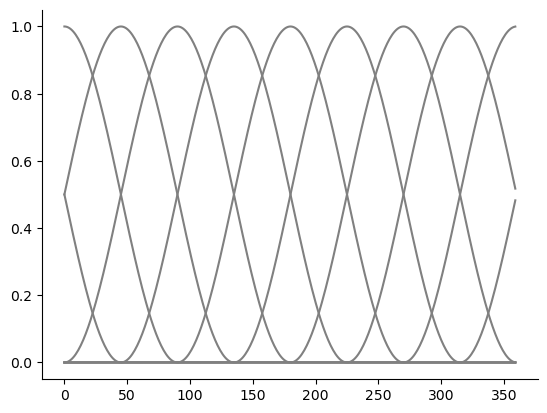

training timepoint 400
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
Best alpha: 100.0
training timepoint 401
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
training timepoint 402
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Best alpha: 1000.0
Be

<Figure size 640x480 with 0 Axes>

In [128]:


def linear_regression_timegen(X_train, X_test, y_train,t_train,t_test):
    ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
    
    pipe = Pipeline([('scaler', StandardScaler()), 
            ('regression', ridge_cv)])
    pipe.fit(X_train[:,:,t_train],y_train)
    predictions = pipe.predict(X_test[:,:,t_test])
    
    best_alpha = pipe.named_steps['regression'].alpha_
    print(f"Best alpha: {best_alpha}")
    return predictions


def run_regression_cross(epochs_train,epochs_test,target_column_train,target_column_test):
    basis_function = make_basis_function()
        
    all_y_pred = []
    all_y_true = []
    all_y_true_deg = []

    X_train = epochs_train._data
    X_test = epochs_test._data
    y_train = epochs_train.metadata[target_column_train]
    y_test = epochs_test.metadata[target_column_test]
    y_train_bf = basis_function[:,y_train].T
    y_test_bf = basis_function[:,y_test].T


    # for t_train in range(len(epochs_train.times)):
    for t_train in range(400,410):
        print(f"training timepoint {t_train}")

        y_predicted = Parallel(n_jobs=8)(delayed(linear_regression_timegen)(X_train, X_test, y_train_bf,t_train,t_test) for t_test in range(X_test.shape[2]))
        all_y_pred.append(y_predicted)
    all_y_true.append(y_test_bf)
    all_y_true_deg.append(y_test)
        
    return np.array(all_y_pred), np.array(all_y_true), np.array(all_y_true_deg)




# run regression across time: training on still, testing on mini-epochs
epochs_mini.metadata['timepoints'] = np.tile(np.arange(0,180),len(epochs_mini.metadata)//180)


target_column_train = 'degrees'
target_column_test = 'frame'
epochs_train = epochs_still
epochs_test = epochs_mini

y_pred, y_true, y_true_deg = run_regression_cross(epochs_train,epochs_test,target_column_train,target_column_test)





In [44]:
epochs_test._data.shape

(90720, 269, 21)

In [43]:
epochs_train._data[:,:,400].shape

(640, 269)

In [28]:
sort_order = np.array([np.argsort(y_true_deg[cv,:])  for cv in range(4)])    
y_pred_sorted = np.array([y_pred[cv,:,sort_order[cv,:],:] for cv in range(4)])
y_true_sorted = np.array([y_true[cv,sort_order[cv,:],:] for cv in range(4)])

# is averaging the right approach? I'm not sure...
y_pred_sorted_avg = np.mean(y_pred_sorted,axis=0)
y_true_sorted_avg = np.mean(y_true_sorted,axis=0)

plt.plot(epochs_still.times,[r2_score(y_true_sorted_avg.T,y_pred_sorted_avg[:,t,:].T) for t in range(len(epochs_still.times))],color='teal')
plt.xlabel('time (s)')
plt.ylabel('r2 score')




AttributeError: 'list' object has no attribute 'shape'

In [115]:
sort_order = np.argsort(y_true_deg.flatten())
y_pred_sorted = y_pred[:,:,sort_order,:]
y_true_sorted = y_true[0,sort_order,:]


y_pred_sorted_avg = np.mean(np.mean(y_pred_sorted,axis=0),axis=0)


In [124]:
s_idx = epochs_mini.metadata.timepoints.to_numpy()[sort_order]==10

In [127]:
r2_score(y_true_sorted[s_idx,:].T,y_pred_sorted_avg[s_idx,:].T)

-8547.13334379915

In [117]:
res = []

for frames in range(180):
    y_t = y_true[0,epochs_mini.metadata.timepoints==frames,:]
    y_p = y_pred[:,:,epochs_mini.metadata.timepoints==frames,:]
    test_sample = 0

    r = np.mean([np.mean([r2_score(y_t.T,y_p[training_sample,test_sample,:,:].T)  for test_sample in range(21)]) for training_sample in range(10)])
    
    res.append(r)

KeyboardInterrupt: 

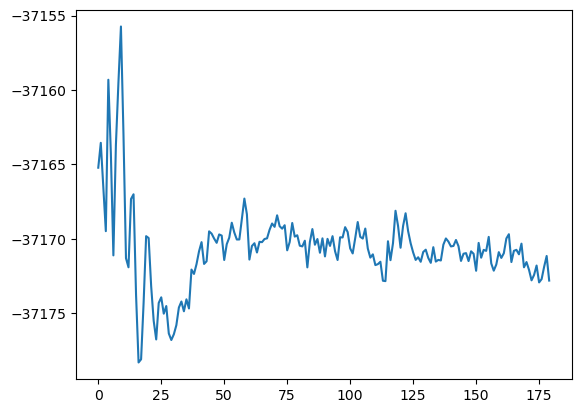

In [ ]:
plt.plot(res)

In [ ]:
np.mean(y_p[training_sample,:,:,:],axis=0).shape

(504, 8)

In [ ]:
y_p[training_sample,:,:,:].shape

(21, 504, 8)